*Contributed by: Darien*

## Model Selection

In [1]:
#pip install -U imbalanced-learn

In [2]:
#conda install -c conda-forge imbalanced-learn

In [3]:
#!pip install imblearn

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 500)

In [5]:
train = pd.read_csv('../assets/train_final.csv')
test = pd.read_csv('../assets/test_final.csv')

In [6]:
# Define X and y for model.
X = train.drop(columns = ['WnvPresent','NumMosquitos'])._get_numeric_data()  #to make the test and train set have the same features; to use numerical data only,if the score is low, will consider to use one-hot encoding
y = train['WnvPresent']

In [7]:
#perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

### Baseline Model

Without any modelling and picking at random, the chance of us correctly positively predicting WNV is around 5.2%.This is an unbalanced dataset and will greatly bias our model.

In [9]:
# Baseline
y = train['WnvPresent']
y.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

Given that the train dataset is imbalanced with only 5% of cases with positive WNV, the use of accuracy as a metric for our model evaluation would be flawed.
- This is because our model would learn to disregard positive-WNV cases, and solely pick up negative-WNV cases (95% of accuracy in this case).
- Additional methods such as under-sampling or oversampling should be done to balance this dataset.
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

## Model Testing

- I will run a list of models with SMOTE and select the model base on ROC_AUC score.
- The area under the ROC curve (AUC) can be interpreted as the probability that the classification model correctly ranks a random positive example higher than a random negative example. So an AUC which is close to 1 is quite often considered to be a confirmation of the model being good.

### Logistic Regression (with SMOTE)

In [10]:
# Applying SMOTE to our datasets
smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
# Performing Standard Scaling on our dataset 
X_train_smt_ss = ss.fit_transform(X_train_smt)

In [11]:
# Fitting to LogReg
lr = LogisticRegression(C=10, max_iter=10000, random_state=42)
lr.fit(X_train_smt_ss, y_train_smt)

LogisticRegression(C=10, max_iter=10000, random_state=42)

In [12]:
# Obtaining the train / test and cross validation score
print("----------Logistic Regression----------")
print(f"X_train score: {lr.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {lr.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(lr, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")

----------Logistic Regression----------
X_train score: 0.7583955223880597
X_test score: 0.5053934010152284
Cross_val training score: 0.7579655620824871


In [13]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, lr.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,1449,1538
actual pos_WNV,21,144


In [14]:
# Generating the classification report
report = classification_report(y_test, 
                               lr.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.985714,0.485102,0.650213,2987.000000
pred pos_WNV,0.085612,0.872727,0.155929,165.000000
accuracy,0.505393,0.505393,0.505393,0.505393


In [15]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, lr.predict_proba(X_test_ss)[:,1])    #Using [:,1] will give you the probability of getting the output as 1.
print('-----Logistic Regression-----')
roc_score

-----Logistic Regression-----


0.7620050521958792

### K-Nearest Neighbors

In [16]:
# Performing Standard Scaling on our dataset
X_train_smt_ss = ss.fit_transform(X_train_smt)

In [17]:
#initialize and fit to the our dataset
knn = KNeighborsClassifier()
knn.fit(X_train_smt_ss, y_train_smt)

KNeighborsClassifier()

In [18]:
# Obtaining the train / test and cross validation score
print("----------K-Nearest Neighbors----------")
print(f"X_train score: {knn.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {knn.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(knn, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")


----------K-Nearest Neighbors----------
X_train score: 0.9466848450057406
X_test score: 0.8239213197969543
Cross_val training score: 0.904923155768565


In [19]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, knn.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,2514,473
actual pos_WNV,82,83


In [20]:
# Generating the classification report
report = classification_report(y_test, 
                               knn.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.968413,0.841647,0.900591,2987.000000
pred pos_WNV,0.149281,0.503030,0.230236,165.000000
accuracy,0.823921,0.823921,0.823921,0.823921


In [21]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, knn.predict_proba(X_test_ss)[:,1])
print("-----K-Nearest Neighbors-----")
roc_score

-----K-Nearest Neighbors-----


0.7400046666869565

### Decision Tree Classifier

In [22]:
#initialize and fit to the our dataset
dt = DecisionTreeClassifier()
dt.fit(X_train_smt_ss, y_train_smt)

DecisionTreeClassifier()

In [23]:
# Obtaining the train / test and cross validation score
print("----------Decision Tree Classifier----------")
print(f"X_train score: {dt.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {dt.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(dt, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")

----------Decision Tree Classifier----------
X_train score: 0.9867250287026407
X_test score: 0.4073604060913706
Cross_val training score: 0.9326217551787472


In [24]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dt.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,1155,1832
actual pos_WNV,36,129


In [25]:
# Generating the classification report
report = classification_report(y_test, 
                               dt.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.969773,0.386676,0.552896,2987.00000
pred pos_WNV,0.065783,0.781818,0.121355,165.00000
accuracy,0.407360,0.407360,0.407360,0.40736


In [26]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, dt.predict_proba(X_test_ss)[:,1])
print("-----Decision Tree Classifier-----")
roc_score

-----Decision Tree Classifier-----


0.5830386219070518

### Support Vector Classifier

In [27]:
#initialize and fit to the our dataset
sv = SVC(probability=True)
sv.fit(X_train_smt_ss, y_train_smt)

SVC(probability=True)

In [28]:
# Obtaining the train / test and cross validation score
print("----------Support Vector Classifier----------")
print(f"X_train score: {sv.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {sv.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(sv, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")

----------Support Vector Classifier----------
X_train score: 0.8814580941446614
X_test score: 0.7763324873096447
Cross_val training score: 0.8656725671631141


In [29]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, sv.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,2341,646
actual pos_WNV,59,106


In [30]:
# Generating the classification report
report = classification_report(y_test, 
                               sv.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.975417,0.783729,0.869129,2987.000000
pred pos_WNV,0.140957,0.642424,0.231189,165.000000
accuracy,0.776332,0.776332,0.776332,0.776332


In [31]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, sv.predict_proba(X_test_ss)[:,1])
print("-----Support Vector Classifier-----")
roc_score

-----Support Vector Classifier-----


0.7518955879518316

### Gradient Boost Classifier

In [32]:
#initialize and fit to the our dataset
gb = GradientBoostingClassifier()
gb.fit(X_train_smt_ss, y_train_smt)

GradientBoostingClassifier()

In [33]:
# Obtaining the train / test and cross validation score
print("----------Gradient Boost Classifier----------")
print(f"X_train score: {gb.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {gb.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(gb, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")

----------Gradient Boost Classifier----------
X_train score: 0.9067881745120551
X_test score: 0.35374365482233505
Cross_val training score: 0.8999723981383957


In [34]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, gb.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,963,2024
actual pos_WNV,13,152


In [35]:
# Generating the classification report
report = classification_report(y_test, 
                               gb.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.986680,0.322397,0.485995,2987.000000
pred pos_WNV,0.069853,0.921212,0.129859,165.000000
accuracy,0.353744,0.353744,0.353744,0.353744


In [36]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, gb.predict_proba(X_test_ss)[:,1])
print("-----Gradient Boost Classifier-----")
roc_score

-----Gradient Boost Classifier-----


0.7256769232329995

### AdaBoost Classifier

In [37]:
#initialize and fit to the our dataset
ab = AdaBoostClassifier()
ab.fit(X_train_smt_ss, y_train_smt)

AdaBoostClassifier()

In [38]:
# Obtaining the train / test and cross validation score
print("----------Ada Boost Classifier----------")
print(f"X_train score: {ab.score(X_train_smt_ss, y_train_smt)}")   # Training set
print(f"X_test score: {ab.score(X_test_ss, y_test)}")   # Test set
print(f"Cross_val training score: {cross_val_score(ab, X_train_smt_ss, y_train_smt, cv=3, n_jobs=-1).mean()}")

----------Ada Boost Classifier----------
X_train score: 0.8653846153846154
X_test score: 0.3531091370558376
Cross_val training score: 0.8651707137297714


In [39]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, ab.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,957,2030
actual pos_WNV,9,156


In [40]:
# Generating the classification report
report = classification_report(y_test, 
                               ab.predict(X_test_ss),
                               target_names=["pred neg_WNV", "pred pos_WNV"], 
                               output_dict=True)

pd.DataFrame(report).drop(["macro avg", "weighted avg"], axis=1).T

,precision,recall,f1-score,support
pred neg_WNV,0.990683,0.320388,0.484189,2987.000000
pred pos_WNV,0.071363,0.945455,0.132709,165.000000
accuracy,0.353109,0.353109,0.353109,0.353109


In [41]:
#compute roc_auc_score
roc_score = roc_auc_score(y_test, ab.predict_proba(X_test_ss)[:,1])
print("-----Ada Boost Classifier-----")
roc_score

-----Ada Boost Classifier-----


0.6925586632985361

In [42]:
init_dict = {
    lr: 'LogisticRegression',
    knn: 'KNeighborsClassifier',
    gb: 'GradientBoostingClassifier',
    ab: 'AdaBoostClassifier',
    sv: 'SupportVectorMachine',
    dt: 'DecisionTreeClassifier',
}

In [43]:
#create function to plot roc_auc curve
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test_ss, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is

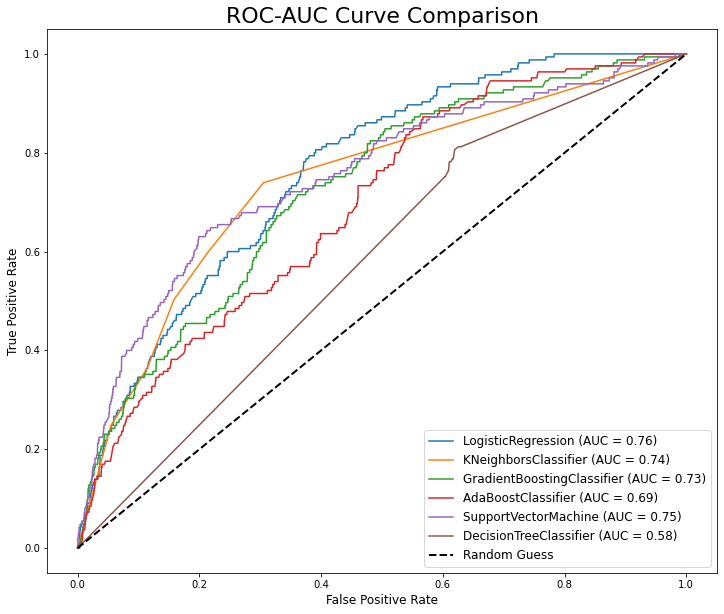

In [44]:
# plot roc_auc curve
roc_curve_plotter(init_dict)

<b>Comments:</b> <br>
From the curve, we observe that K-Nearest Neighbors and Decision Tree have a sharp drop off after a specific threshold. We can conclude that Logistic Regression has the best ROC-AUC score. 